In [ ]:
import pandas as pd
import numpy as np

In [12]:

from sklearn.preprocessing import StandardScaler

def preprocess_data(data):
    numeric_data = data.copy()
        
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(
        scaler.fit_transform(numeric_data),
        columns=numeric_data.columns
    )
    
    return scaled_data

def calculate_mahalanobis_similarity(vector1, vector2, inv_covariance_matrix):
    diff = vector1 - vector2
    distance = np.sqrt(diff.dot(inv_covariance_matrix).dot(diff))
    return np.exp(-distance)

def get_recommendations(user_profile, train_data, k=5):
    covariance_matrix = np.cov(train_data.values.T)
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)
    
    similarities = np.array([
        calculate_mahalanobis_similarity(
            user_profile.iloc[0].values,
            train_data.iloc[i].values,
            inv_covariance_matrix
        )
        for i in range(len(train_data))
    ])
    
    similar_indices = np.argsort(similarities)[-k:]
    return train_data.iloc[similar_indices], similarities[similar_indices]

def fill_test_values(test_data, train_data):
    filled_predictions = test_data.copy()
    
    for idx in range(len(test_data)):
        test_user = test_data.iloc[[idx]]
        similar_users, similarities = get_recommendations(test_user, train_data)
        
        # Normalize similarities to weights
        weights = similarities / np.sum(similarities)
        weighted_predictions = np.average(similar_users, weights=weights, axis=0)
        filled_predictions.iloc[idx] = np.round(weighted_predictions)
    
    return filled_predictions

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error

def calculate_accuracy_metrics(evaluation, threshold=0.5):
    y_true = evaluation['score'] >= threshold
    y_pred = evaluation['prediction'] >= threshold
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return precision, recall, f1

def calculate_error_metrics(evaluation):
    y_true = evaluation['score']
    y_pred = evaluation['prediction']
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return mae, rmse

def calculate_ranking_metrics(evaluation):
    def average_precision(y_true, y_pred):
        sorted_indices = np.argsort(y_pred)[::-1]
        y_true_sorted = np.array(y_true)[sorted_indices]
        cumsum = np.cumsum(y_true_sorted)
        precision_at_k = cumsum / (np.arange(len(y_true_sorted)) + 1)
        return np.sum(precision_at_k * y_true_sorted) / np.sum(y_true_sorted)
    
    def ndcg(y_true, y_pred, k=10):
        sorted_indices = np.argsort(y_pred)[::-1]
        y_true_sorted = np.array(y_true)[sorted_indices]
        dcg = np.sum((2**y_true_sorted - 1) / np.log2(np.arange(1, len(y_true_sorted) + 1) + 1))
        ideal_sorted_indices = np.argsort(y_true)[::-1]
        y_true_ideal_sorted = np.array(y_true)[ideal_sorted_indices]
        idcg = np.sum((2**y_true_ideal_sorted - 1) / np.log2(np.arange(1, len(y_true_ideal_sorted) + 1) + 1))
        return dcg / idcg
    
    y_true = evaluation['score']
    y_pred = evaluation['prediction']
    
    map_score = average_precision(y_true, y_pred)
    ndcg_score = ndcg(y_true, y_pred)
    
    return map_score, ndcg_score

## Load

In [13]:
train = pd.read_csv("../../data/train/user_item.csv").set_index("profile_id")
train.head()

,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
profile_id,,,,,,,,,,
86becbd667a94db3a3dee0854470de7c,0,0,0,4,0,0,0,3,6,2
676ee3fbf66b46078484ecaa99bc8d1a,4,0,0,0,0,0,0,0,3,4
fada060561c24d4a984cc6eba6e2a63a,0,4,0,0,0,0,0,0,0,2
5cd3b3a0e5284df1adf8cca2f59ed28f,0,4,12,0,0,0,0,3,0,0
8a6a2df8be214007991afb612eb64c1c,0,0,0,0,0,3,3,0,0,0


In [14]:
test = pd.read_csv("../../data/test/user_item.csv").set_index("profile_id")
test.head()

,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
profile_id,,,,,,,,,,
b19c8e7ac2ff40ae92b4fcf3247f8912,0,4,4,0,3,0,0,0,0,0
0b680efe1a0a40788ebb6fb2c587b4a7,0,0,0,0,3,0,0,3,0,0
9232bc9e68744227bdcc537e44d159f7,0,4,0,4,0,0,0,3,3,2
6e7d42fc10ee466c80a4056b3ec0b072,0,4,0,4,0,3,0,3,0,0
72257b80d8c1407ead2b3af3e7891c25,0,4,0,4,0,0,3,3,3,0


## Transform

In [15]:
# Preprocess data
train_processed = preprocess_data(train)
test_processed = preprocess_data(test)

## Predict

In [16]:
# Make predictions
predicted = fill_test_values(test_processed, train_processed)
predicted.head()

,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-0.0,-0.0,-0.0,-0.0
1,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-0.0,1.0,-0.0,-0.0
2,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-0.0,1.0,2.0,2.0
3,-1.0,1.0,-1.0,1.0,-1.0,1.0,-0.0,1.0,-0.0,-0.0
4,-1.0,0.0,-1.0,1.0,-1.0,-1.0,2.0,1.0,2.0,-0.0


## Test

Mean Squared Error: 0.1568
Root Mean Squared Error: 0.3960
Mean Absolute Error: 0.3557
R-squared Score: 0.8432


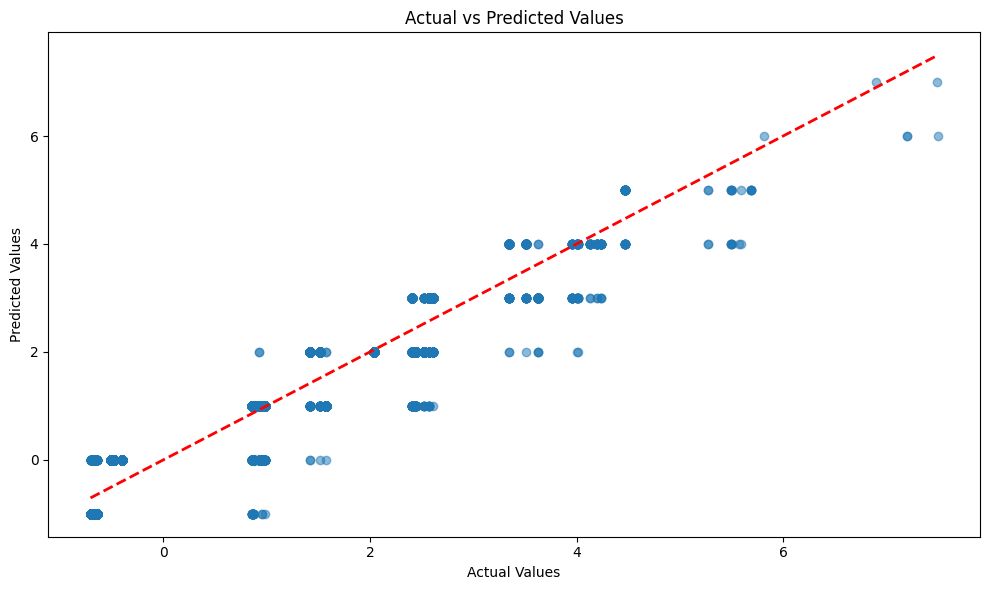

In [17]:
from sklearn.metrics import mean_squared_error
import seaborn as sns

import matplotlib.pyplot as plt

# Create comparison and calculate metrics
test_preprocessed_values = test_processed.values
predicted_values = predicted.values

# Calculate MSE and RMSE
mse = mean_squared_error(test_preprocessed_values, predicted_values)
rmse = np.sqrt(mse)

# Calculate additional metrics
mae = np.mean(np.abs(test_preprocessed_values - predicted_values))
r2 = 1 - (np.sum((test_preprocessed_values - predicted_values) ** 2) / 
          np.sum((test_preprocessed_values - np.mean(test_preprocessed_values)) ** 2))

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Create scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test_preprocessed_values.flatten(), predicted_values.flatten(), alpha=0.5)
plt.plot([test_preprocessed_values.min(), test_preprocessed_values.max()], 
         [test_preprocessed_values.min(), test_preprocessed_values.max()], 
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

## Save

In [19]:
# Add profile_id back to the predicted DataFrame
predicted.index = test.index
predicted.columns = test.columns
predicted = predicted.reset_index()
predicted.head()

,profile_id,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
0,b19c8e7ac2ff40ae92b4fcf3247f8912,-1.0,1.0,1.0,-1.0,1.0,-1.0,-0.0,-0.0,-0.0,-0.0
1,0b680efe1a0a40788ebb6fb2c587b4a7,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-0.0,1.0,-0.0,-0.0
2,9232bc9e68744227bdcc537e44d159f7,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-0.0,1.0,2.0,2.0
3,6e7d42fc10ee466c80a4056b3ec0b072,-1.0,1.0,-1.0,1.0,-1.0,1.0,-0.0,1.0,-0.0,-0.0
4,72257b80d8c1407ead2b3af3e7891c25,-1.0,0.0,-1.0,1.0,-1.0,-1.0,2.0,1.0,2.0,-0.0


In [20]:
# Add profile_id back to the predicted DataFrame
predicted.to_csv("../../data/predictions/collaborative_filters_mahalanobis.csv", index=False)